In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),
                             "../src"))
from utils import *

import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Import Torch's main library for computer vision

In [2]:
import torchvision
print(torchvision.__version__)

0.15.1


In [3]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

## Getting a dataset - we're going to be using fashion MNIST dataset

In [4]:
root = "../Datasets/FashionMNIST"
if not os.path.exists(root):
    os.makedirs(root)

In [5]:
train_data = datasets.FashionMNIST(root = root,
                                   train = True,
                                   download = True,
                                   transform = ToTensor(),
                                   target_transform = None
                                   )

test_data = datasets.FashionMNIST(root = root,
                                  train = False,
                                  download = True,
                                  transform = ToTensor(),
                                  target_transform = None
                                   )

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
image, label = train_data[0]
type(image), type(label)

(torch.Tensor, int)

In [8]:
classes = {v:k for k, v in train_data.class_to_idx.items()}
classes

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

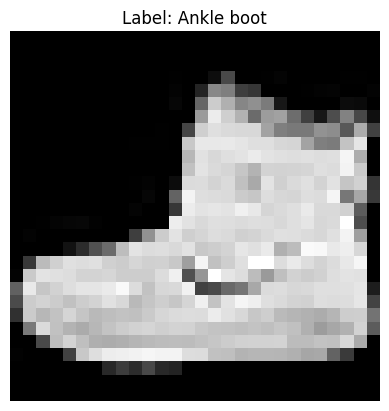

In [9]:
image, label = train_data[0]
plt.imshow(image.permute(1,2,0), cmap='gray')
plt.title(f'Label: {classes[label]}');
plt.axis('off');

In [10]:
image.shape

torch.Size([1, 28, 28])

This means that we only have a color channel of 1 - this is a greyscale image

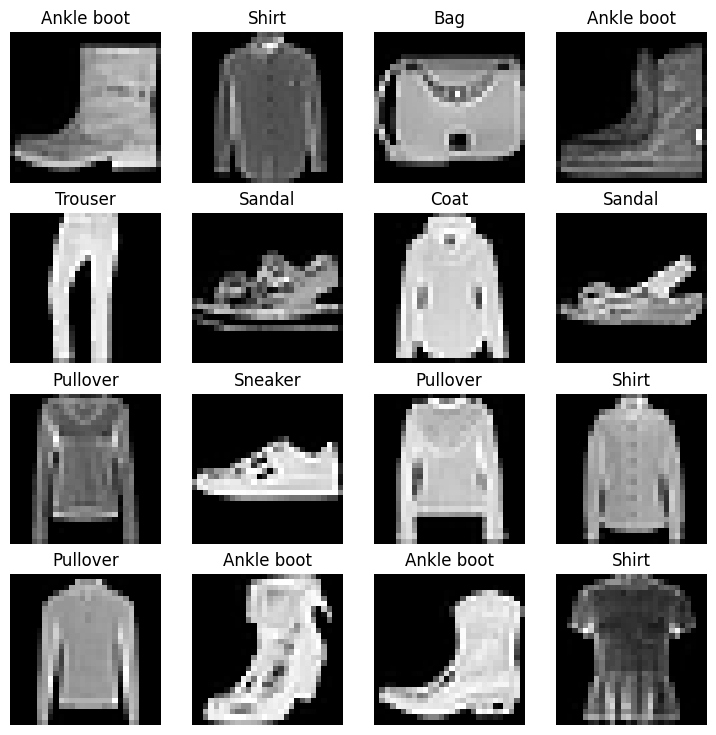

In [11]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4,4

for i in range(1, rows * cols +1):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label]);
    plt.axis(False);

In [12]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

## Dataloaders - a PyTorch requirement
Right now our data is in the form of `torchvision.dataset`. A dataloader turns our dataset into a python iterable. Specifically, we want to turn our data into batches.

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
SEED = 42

train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader  = DataLoader(test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

In [14]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

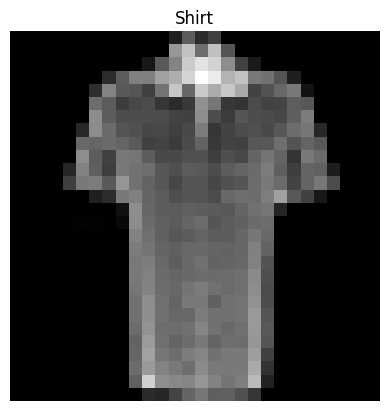

In [16]:
torch.manual_seed(SEED)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), #because it's from a dataloader, the dimension is 1x1x28x28
           cmap = "gray");
plt.title(classes[int(label)]);
plt.axis(False);

In [17]:
device = get_device()
device

'mps'

## Model 0: Using linear layers
All subsequent models must beat this baseline

In [48]:
flat = nn.Flatten()
flattened = flat(img)
flattened.shape

torch.Size([1, 784])

In [18]:
class linearModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features = hidden_units),
            nn.Linear(in_features= hidden_units,
                      out_features = output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

This isn't going to yield the best results because there are no non-linearities in the model.

In [19]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

model0 = linearModel(input_shape = 28*28,
                     hidden_units = 10,
                     output_shape = len(classes)).to('cpu')

In [20]:
dummy_x = torch.rand([1,1,28,28])
model0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

Yup this is the output shape that we need

In [21]:
loss_fn = nn.CrossEntropyLoss() #multi-classification problem
optimizer = torch.optim.SGD(model0.parameters(),
                            lr = 0.1)

Creating a function to time our experiments

In [22]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")

### Train model 0

In [23]:
from tqdm.auto import tqdm

Training on cpu:

In [24]:
torch.manual_seed(SEED)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_loss = 0
    
    #Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model0.train()
        train_pred = model0(X)
        loss = loss_fn(train_pred, y)
        train_loss += loss #accumulate training loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")
    
    #Compute average loss per epoch - because train_loss is accumulated
    train_loss /= len(train_dataloader)
    
    ## Testing
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model0(X_test)
            test_loss+=loss_fn(test_pred, y_test)
            
            # Compute accuracy
            test_acc += classification_accuracy(y_test, test_pred.argmax(dim=1))
        
        #Calculate average test loss per batch
        test_loss /= len(test_dataloader)
        
        #Calculate test acc average per batch
        test_acc /= len(test_dataloader)
    
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc}%")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start = train_time_start_on_cpu,
    end = train_time_end_on_cpu,
    device = str(next(model0.parameters()).device)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.03873801916933%
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.19688498402556%
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.42651757188499%
Train time on cpu: 7.311 seconds


### Make predictions and get model 0 results

In [25]:
torch.manual_seed(SEED)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting
    on dataloader

    Args:
        model (torch.nn.Module): _description_
        loss_fn (torch.nn.Module): _description_
        accuracy_fn (_type_): _description_
        data_loader (_type_, optional): _description_. Defaults to torch.utils.data.DataLoader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make preds
            y_pred = model(X)
            
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true = y,
                               y_pred = y_pred.argmax(dim=1))
        
        loss/= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

#Calculate model 0's results on test dataset
model0_results = eval_model(model = model0,
                            data_loader = test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn = classification_accuracy,
                            device = 'cpu')

model0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'linearModel',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

It looks like our baseline model without any non-linearity is already doing reasonably well.

## Model 1: Using non-linear activation functions

In [26]:
class nonLinearModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, out_features),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_stack(x)

In [27]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               accuracy_fn = None):
    """Trains the model for each epoch

    Args:
        model (torch.nn.Module): Instantiated model object
        dataloader (torch.utils.data.Dataloader): Instantiated dataloader object
        optimizer (torch.optim.Optimizer): Optimizer function
        device (str): Device that the model is placed on. Defaults to torch.device.
        accuracy_fn: A defined python function to compute classification accuracy. Defaults to "None"
    """
    model.train()
    train_acc, train_loss = 0, 0
    
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)
        
        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss #accumulate train loss
        
        if accuracy_fn is not None:
            train_acc += accuracy_fn(y_true = y,
                                     y_pred = y_pred.argmax(dim=1) #logits to pred labels
                                     )
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(dataloader)
    
    if train_acc != 0:
        train_acc/=len(dataloader)
        print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
    
    else:
        print(f"Train loss: {train_loss:.5f}")
    

In [28]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              accuracy_fn = None,):
    """Performs a testing loop step using model on dataloader

    Args:
        model (torch.nn.Module): Instantiated model object
        dataloader (torch.utils.data.Dataloader): Instantiated dataloader object
        device (str): Device that the model is placed on. Defaults to torch.device.
        accuracy_fn: A defined python function to compute classification accuracy. Defaults to "None"
    """
    test_loss, test_acc = 0, 0
    
    model.eval()
    
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            
            if accuracy_fn is not None:
                test_acc += accuracy_fn(y_true = y,
                                        y_pred = test_pred.argmax(dim=1)
                                        )
            
        # Adjust metrics
        test_loss/=len(dataloader)
        
        if test_acc !=0:
            test_acc/=len(dataloader)
            print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
        
        else:
            print(f"Test loss: {test_loss:.5f}")

Train and test

In [29]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

train_time_start_on_cpu = timer()

model1 = nonLinearModel(784, len(classes), 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(),
                            lr = 0.1)
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_step(model = model1,
               dataloader = train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               accuracy_fn = classification_accuracy,
               device = device)
    test_step(model = model1,
              dataloader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = classification_accuracy,
              device = device)

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start = train_time_start_on_cpu,
    end = train_time_end_on_cpu,
    device = str(next(model1.parameters()).device)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.84236 | Train acc: 70.14%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.71832 | Test acc: 73.64%
Epoch: 1
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.67832 | Train acc: 75.39%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.67587 | Test acc: 75.49%
Epoch: 2
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.64944 | Train acc: 76.24%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.71171 | Test acc: 74.31%
Train time on mps:0: 25.099 seconds


In [30]:
model1_results = eval_model(model = model1,
                            data_loader = test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn = classification_accuracy,
                            device = device)

model1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'nonLinearModel',
 'model_loss': 0.7117101550102234,
 'model_acc': 74.31110223642173}

## Model 2: Using a CNN

In [31]:
class ConvLearner(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units *7 *7,
                      out_features = output_shape)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        # print(f"Ouput shape of conv_block1: {x.shape}")
        x = self.conv_block2(x)
        # print(f"Ouput shape of conv_block2: {x.shape}")
        x = self.classifier(x)
        return x

In [32]:
device = get_device()

In [33]:
torch.manual_seed(42)
model2 = ConvLearner(input_shape = 1, #only one color channel
                     hidden_units = 10,
                     output_shape = len(classes)).to(device)

Stepping through nn.Conv2D

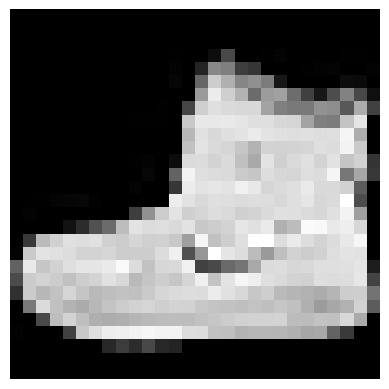

In [10]:
plt.imshow(image.squeeze(), cmap = 'gray')
plt.axis(False);

In [34]:
image.shape

torch.Size([1, 28, 28])

In [35]:
model2(image.unsqueeze(0).to(device))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='mps:0', grad_fn=<LinearBackward0>)

Training our CNN

In [36]:
SEED = 42
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

train_time_start_on_cpu = timer()

device = get_device()

model2 = ConvLearner(input_shape = 1, #only one color channel
                     hidden_units = 10,
                     output_shape = len(classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(),
                            lr = 0.1)

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_step(model = model2,
               dataloader = train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               accuracy_fn = classification_accuracy,
               device = device)
    test_step(model = model2,
              dataloader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = classification_accuracy,
              device = device)

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start = train_time_start_on_cpu,
    end = train_time_end_on_cpu,
    device = str(next(model2.parameters()).device)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.59816 | Train acc: 78.09%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.42465 | Test acc: 85.46%
Epoch: 1
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.35019 | Train acc: 87.43%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.34754 | Test acc: 87.33%
Epoch: 2
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.31189 | Train acc: 88.85%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.35493 | Test acc: 86.44%
Train time on mps:0: 34.826 seconds


In [37]:
model2_results = eval_model(model = model2,
                            data_loader = test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn = classification_accuracy,
                            device = device)

model2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ConvLearner',
 'model_loss': 0.35493308305740356,
 'model_acc': 86.44169329073482}

Nice! We got something that beats the baseline!

## Comparing the results of our modelling experiments

In [38]:
import pandas as pd
compare_results = pd.DataFrame([model0_results,
                                model1_results,
                                model2_results])
compare_results

,model_name,model_loss,model_acc
0,linearModel,0.476639,83.426518
1,nonLinearModel,0.711710,74.311102
2,ConvLearner,0.354933,86.441693


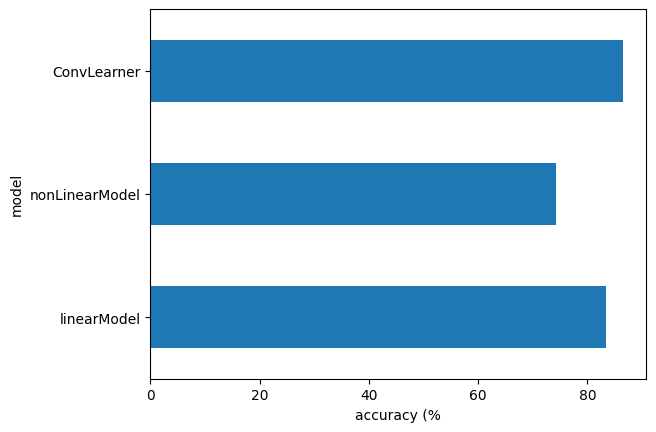

In [39]:
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%');
plt.ylabel('model');

## Making visual predictions using our best performing model

In [58]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device: torch.device = device):
    """Generates a list of predictions given a list of data

    Args:
        model (torch.nn.Module): Model instance
        data (list): List of img tensors to run inference
        device (torch.device, optional): Defaults to device.

    Returns:
        _type_: _description_
    """
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prep sample - add the batch dimension and pass to device
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass
            pred_logit = model(sample)
            
            #Get prediction orobability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
            
            pred_probs.append(pred_prob.cpu())
    
    #Stack pred_probs in list into tensor
    return torch.stack(pred_probs)

In [43]:
import random

random.seed(SEED)
test_samples, test_labels = [], []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

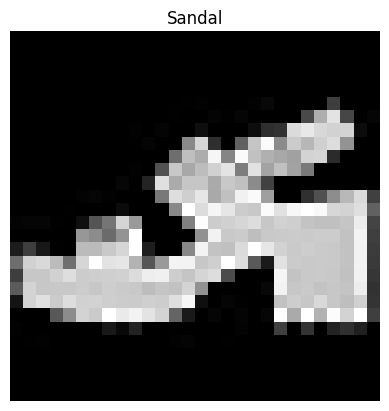

In [46]:
plt.imshow(test_samples[0].squeeze(), cmap = 'gray');
plt.title(classes[test_labels[0]]);
plt.axis(False);

In [47]:
pred_probs = make_predictions(model = model2,
                              data = test_samples)
pred_probs[0]

tensor([5.8290e-07, 7.7969e-08, 1.1991e-08, 3.0820e-07, 1.9275e-08, 9.9995e-01,
        4.7362e-06, 4.5708e-06, 1.5592e-05, 2.7244e-05])

In [53]:
# Convert prediction probabilities to labels
pred_labels = pred_probs.argmax(dim=1).tolist()
pred_labels

[5, 1, 7, 4, 3, 6, 4, 7, 1]

In [51]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

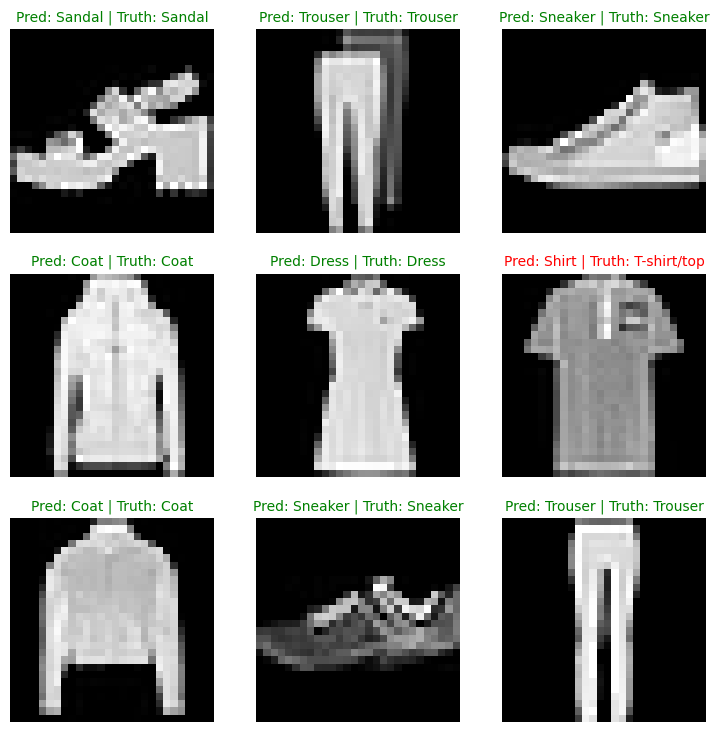

In [57]:
#Plot predictions
plt.figure(figsize = (9,9))
nrows, ncols = 3,3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap = "gray")
    pred_label = classes[pred_labels[i]]
    truth_label = classes[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False);

Plot confusion matrix

In [66]:
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.4 MB/s eta 0:00:00a 0:00:01


In [68]:
from tqdm.auto import tqdm

# make predictions with trained model
y_preds = []
model2.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc = "Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 0])

In [69]:
len(y_pred_tensor)

10000

In [74]:
y_pred_tensor.numpy()

array([9, 2, 1, ..., 8, 1, 0])

In [73]:
test_data.targets.numpy()

array([9, 2, 1, ..., 8, 1, 5])

In [81]:
classes

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

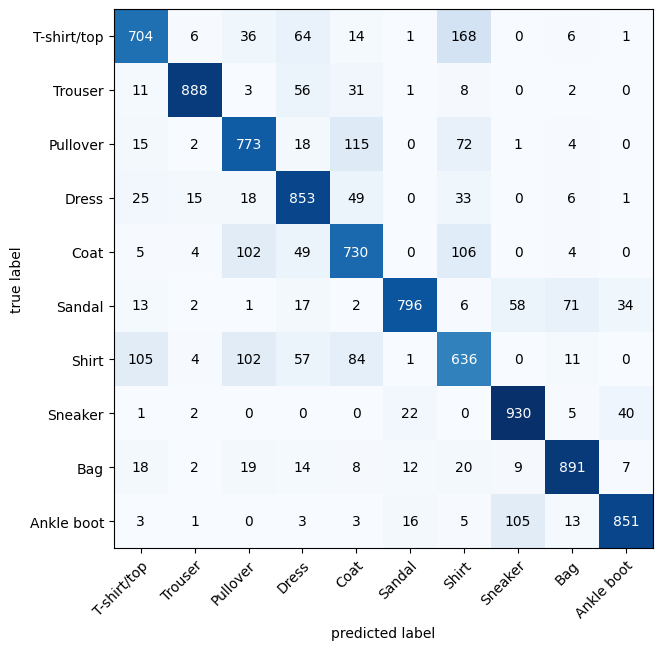

In [87]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cf = confusion_matrix(y_true = test_data.targets.numpy(),
                      y_pred = y_pred_tensor.numpy())

fig, ax  = plot_confusion_matrix(
    cf,
    class_names = classes.values(),
    figsize = (10,7)
)

## Saving and loading our best model

In [89]:
from pathlib import Path

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok = True)
MODEL_NAME = "03_pytorch_cv_model2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: Models/03_pytorch_cv_model2.pth


In [90]:
# Create a new instance of model 2

torch.manual_seed(SEED)

best_model = ConvLearner(input_shape = 1,
                         hidden_units = 10,
                         output_shape = len(classes))
best_model.load_state_dict(
    torch.load(f=MODEL_SAVE_PATH)
)

best_model.to(device)

ConvLearner(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [91]:
eval_model(model = best_model,
           data_loader = test_dataloader,
           loss_fn = loss_fn,
           accuracy_fn = classification_accuracy)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ConvLearner',
 'model_loss': 0.35493308305740356,
 'model_acc': 86.44169329073482}

Yup the loaded model's results are similar!

# Assignment

In [129]:
import os
from pathlib import Path
from timeit import default_timer as timer
import sys
sys.path.append("../src")
from utils import *

import random

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

Hyperparameters

In [126]:
BATCH_SIZE = 32
SEED = 42
device = get_device()
print(device)

mps


Get data

In [95]:
root = "../Datasets/MNIST"
if not os.path.exists(root):
    os.makedirs(root)

train_data = datasets.MNIST(root = root,
                            train = True,
                            download = True,
                            transform = ToTensor(),
                            target_transform = None
                            )

test_data = datasets.MNIST(root = root,
                           train = False,
                           download = True,
                           transform = ToTensor(),
                           target_transform = None
                           )

100%|██████████| 9912422/9912422 [00:00<00:00, 26449066.77it/s]


Extracting ../Datasets/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../Datasets/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6424933.37it/s]

Extracting ../Datasets/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../Datasets/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6932751.85it/s]


Extracting ../Datasets/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Datasets/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8414544.51it/s]

Extracting ../Datasets/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Datasets/MNIST/MNIST/raw



In [96]:
train_dataloader = DataLoader(train_data, 
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(test_data, 
                             batch_size = BATCH_SIZE,
                             shuffle = False)
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [97]:
classes = {v:k for k, v in train_data.class_to_idx.items()}
classes

{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

Visualization

In [102]:
sample_idx = random.sample(list(range(len(train_data))), k = 5)
sample_idx

[14328, 15247, 33118, 39453, 1739]

In [105]:
img, label = train_data[0]
label, img.shape

(5, torch.Size([1, 28, 28]))

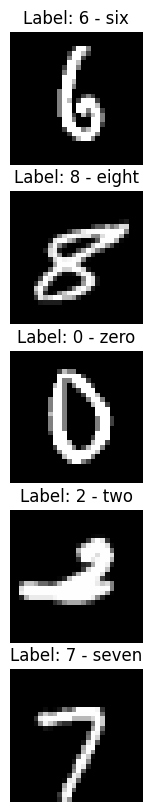

In [108]:
fig = plt.figure(figsize = (10,10))
nrows, ncols = 5, 1
for i, idx in enumerate(sample_idx, 1):
    img, label = train_data[idx]
    plt.subplot(nrows, ncols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title(f"Label: {classes[label]}")
    plt.axis(False)

Once again this is a grayscale image

In [131]:
class ConvLearner(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.ConvStack1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.ConvStack2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units *2 *2,
                      out_features = output_shape)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.ConvStack1(x)
        # print(f"Shape after passing through first conv stack {x.shape}")
        x = self.ConvStack2(x)
        # print(f"Shape after passing through second conv stack {x.shape}")
        x = self.classifier(x)
        return x

In [133]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

train_start_time = timer()
model = ConvLearner(input_shape = 1, 
                    hidden_units = 10, 
                    output_shape = len(classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr = 0.1)

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_step(model = model,
               dataloader = train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               device = device,
               accuracy_fn = classification_accuracy)
    test_step(model = model,
              dataloader = test_dataloader,
              loss_fn = loss_fn,
              device = device,
              accuracy_fn = classification_accuracy)

train_end_time = timer()

train_duration = print_train_time(start = train_start_time,
                                  end = train_end_time,
                                  device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.50318 | Train acc: 82.53%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.09685 | Test acc: 96.85%
Epoch: 1
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.09348 | Train acc: 97.06%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.06148 | Test acc: 98.00%
Epoch: 2
------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.06980 | Train acc: 97.81%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.05295 | Test acc: 98.32%
Train time on mps: 38.937 seconds


In [134]:
model_results = eval_model(model = model,
                           data_loader = test_dataloader,
                           loss_fn = loss_fn,
                           accuracy_fn = classification_accuracy,
                           device = device)
model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ConvLearner',
 'model_loss': 0.05294633284211159,
 'model_acc': 98.3226837060703}

Save model

In [135]:
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok = True)
MODEL_NAME = "03_pytorch_cv_assignment_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj = model.state_dict(),
           f = MODEL_SAVE_PATH)
print(f"Saved model state dict to: {MODEL_SAVE_PATH}")

Saved model state dict to: Models/03_pytorch_cv_assignment_model.pth


In [137]:
loaded_model = ConvLearner(input_shape = 1,
                           hidden_units = 10,
                           output_shape = len(classes))
loaded_model.load_state_dict(
    torch.load(MODEL_SAVE_PATH),
)

loaded_model.to(device)

ConvLearner(
  (ConvStack1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvStack2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)

In [140]:
eval_model(model = loaded_model,
           data_loader = test_dataloader,
           loss_fn = loss_fn,
           accuracy_fn = classification_accuracy,
           device = device)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ConvLearner',
 'model_loss': 0.05294633284211159,
 'model_acc': 98.3226837060703}

Get confusion matrix

In [141]:
# Get predictions

y_preds = []
loaded_model.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        y_logits = loaded_model(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1)
        y_preds.append(y_pred.to('cpu'))

y_preds = torch.cat(y_preds).numpy()
y_preds

  0%|          | 0/313 [00:00<?, ?it/s]

array([7, 2, 1, ..., 4, 0, 6])

In [145]:
y_test = test_data.targets.numpy()

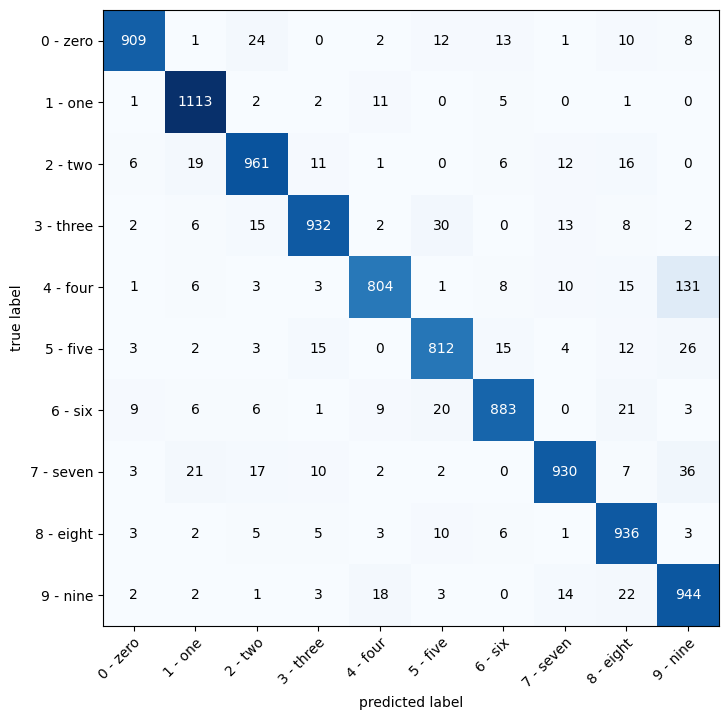

In [149]:
cf = confusion_matrix(y_true = y_test,
                      y_pred = y_preds)
fig, ax = plot_confusion_matrix(cf,
                                class_names = classes.values(),
                                figsize = (10,8))

Plotting predictions

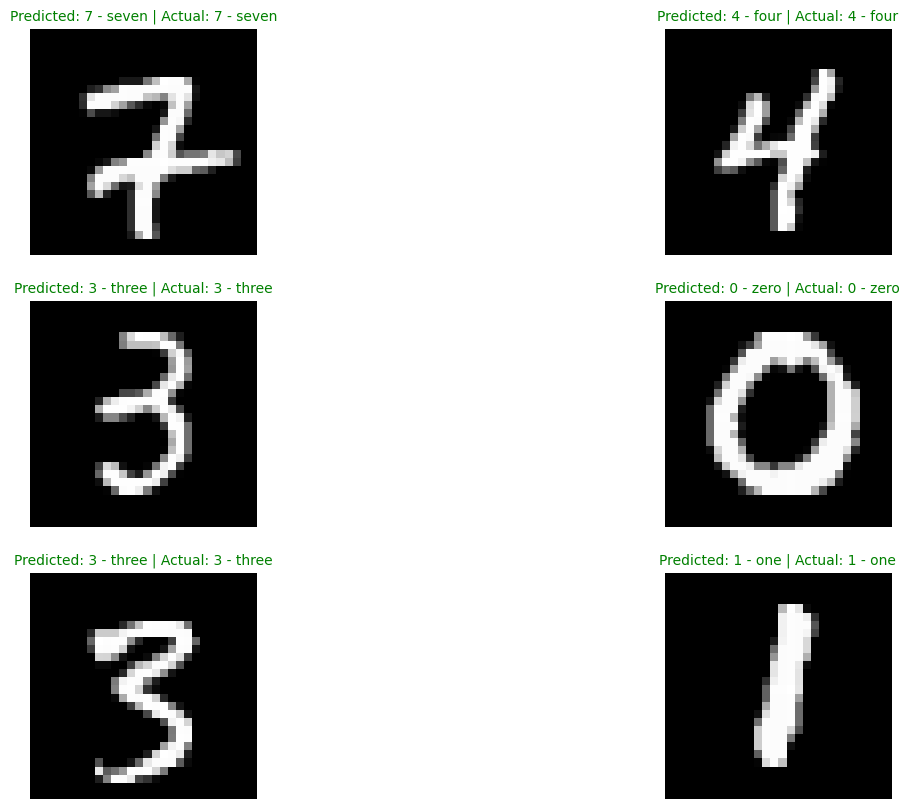

In [156]:
nrows, ncols = 3, 2
sample_idxs = random.sample(list(range(len(test_data))), k = 6)

fig = plt.figure(figsize = (15,10))
for i, idx in enumerate(sample_idxs, 1):
    plt.subplot(nrows, ncols, i)
    img, label = test_data[idx]
    plt.imshow(img.squeeze(), cmap = 'gray')
    pred, actual = classes[y_preds[idx]], classes[label]
    title_string = f"Predicted: {pred} | Actual: {actual}"
    if pred == actual:
        plt.title(title_string, fontsize = 10, c = "g")
    else:
        plt.title(title_string, fontsize = 10, c = "r")
    plt.axis(False)
